# Task for Today  

***

## Cat and Dog Classification  

Given *images of cats and dogs*, let's try to classify which **pet** is present in a given image.

We will use a TensorFlow/Keras CNN to make our predictions.

# Getting Started

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [2]:
image_dir = Path('../input/cat-and-dog-images-dataset/Dog and Cat .png')

# Create File DataFrame

In [3]:
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [4]:
image_df

,Filepath,Label
0,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
1,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
2,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
3,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
4,../input/cat-and-dog-images-dataset/Dog and Ca...,Dog
...,...,...
994,../input/cat-and-dog-images-dataset/Dog and Ca...,Cat
995,../input/cat-and-dog-images-dataset/Dog and Ca...,Cat
996,../input/cat-and-dog-images-dataset/Dog and Ca...,Cat
997,../input/cat-and-dog-images-dataset/Dog and Ca...,Cat


In [5]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Load Image Data

In [6]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [7]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 560 validated image filenames belonging to 2 classes.
Found 139 validated image filenames belonging to 2 classes.
Found 300 validated image filenames belonging to 2 classes.


# Training

In [8]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)

Epoch 1/100
18/18 [==============================] - 19s 881ms/step - loss: 0.6931 - accuracy: 0.5271 - val_loss: 0.6911 - val_accuracy: 0.4964
Epoch 2/100
18/18 [==============================] - 11s 599ms/step - loss: 0.6908 - accuracy: 0.5291 - val_loss: 0.6854 - val_accuracy: 0.5971
Epoch 3/100
18/18 [==============================] - 11s 614ms/step - loss: 0.6812 - accuracy: 0.5987 - val_loss: 0.6822 - val_accuracy: 0.5899
Epoch 4/100
18/18 [==============================] - 10s 580ms/step - loss: 0.6659 - accuracy: 0.6469 - val_loss: 0.6713 - val_accuracy: 0.5827
Epoch 5/100
18/18 [==============================] - 10s 578ms/step - loss: 0.6728 - accuracy: 0.6030 - val_loss: 0.6763 - val_accuracy: 0.5324
Epoch 6/100
18/18 [==============================] - 11s 610ms/step - loss: 0.6609 - accuracy: 0.6322 - val_loss: 0.6873 - val_accuracy: 0.5036
Epoch 7/100
18/18 [==============================] - 10s 584ms/step - loss: 0.6714 - accuracy: 0.5948 - val_loss: 0.6969 - val_accuracy:

# Results

In [9]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.65611
Test Accuracy: 62.33%


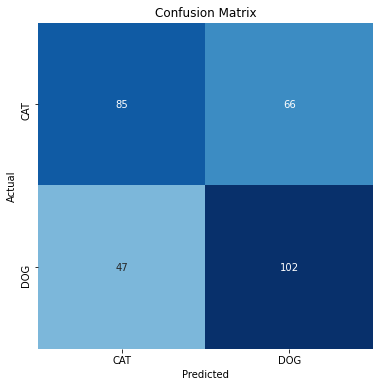

Classification Report:
----------------------
               precision    recall  f1-score   support

         CAT       0.64      0.56      0.60       151
         DOG       0.61      0.68      0.64       149

    accuracy                           0.62       300
   macro avg       0.63      0.62      0.62       300
weighted avg       0.63      0.62      0.62       300



In [10]:
predictions = (model.predict(test_images) >= 0.5).astype(np.int)

cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["CAT", "DOG"])

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.yticks(ticks=[0.5, 1.5], labels=["CAT", "DOG"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)

# Data Every Day  

This notebook is featured on Data Every Day, a YouTube series where I train models on a new dataset each day.  

***

Check it out!  
https://youtu.be/jZVVFUhsbgY